In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data

from abtem import GridScan, PixelatedDetector, PotentialArray, Probe
from abtem.reconstruct import epie

# Reconstruction of weak phase object using the ePIE algorithm

We define a pure phase test object and our source of illumination.

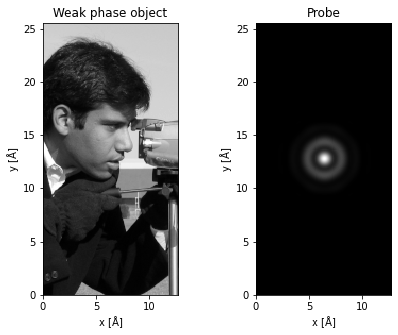

In [3]:
image = data.camera().astype(np.float32)
image = image[50:50+2*128,170:170+128].T[:,::-1]
image = image / image.max() * 1e3
potential = PotentialArray(image[None], [0.], sampling=.1)

probe = Probe(semiangle_cutoff=20, energy=80e3, defocus=300, Cs=1e6)
probe.grid.match(potential)

fig,(ax1,ax2)= plt.subplots(1,2, figsize=(7,5))
potential.project().show(ax=ax1, title='Weak phase object')
probe.show(ax=ax2, title='Probe');

We simulate 2304 diffraction patterns covering the entire test object.

In [11]:
gridscan = GridScan((0,0), potential.extent, sampling=1)
detector = PixelatedDetector(None)
measurement = probe.scan(gridscan, [detector], potential)

Scan:   0%|          | 0/338 [00:00<?, ?it/s]

Note, as can be seen below, abTEM use a 2/3 antialising aperture.

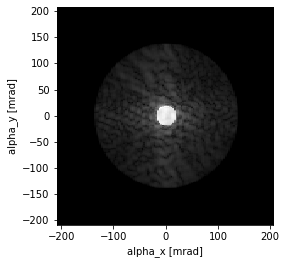

In [6]:
measurements[10,10].show(power=.2);

We have to define our guess for the probe. In this test, we assume that the convergence angle and energy is known, but we don't know the defocus or spherical aberration.

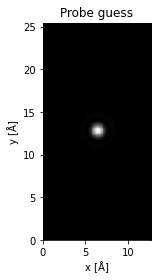

In [7]:
probe_guess = probe.copy()
probe_guess.ctf.defocus = 0
probe_guess.ctf.Cs = 0
probe_guess.show(title='Probe guess');

Run the ePIE algorithm for 5 iterations (expect this to take around 2-3 min).

In [12]:
reconstructions = epie(measurement, probe_guess, maxiter=8, return_iterations=True, fix_com=False, device='gpu')

C:\Users\jacob\anaconda3\envs\abTEM_interactive\lib\site-packages\cupy\fft\_fft.py:451: UserWarning: cuFFT plan cache is disabled on CUDA 11.1 due to a known bug, so performance may be degraded. The bug is fixed on CUDA 11.2+.
  cache = get_plan_cache()


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/338 [00:00<?, ?it/s]

The result after each iteration is shown below. Note, that your results may vary slightly, as the diffraction measurements are accessed randomly.

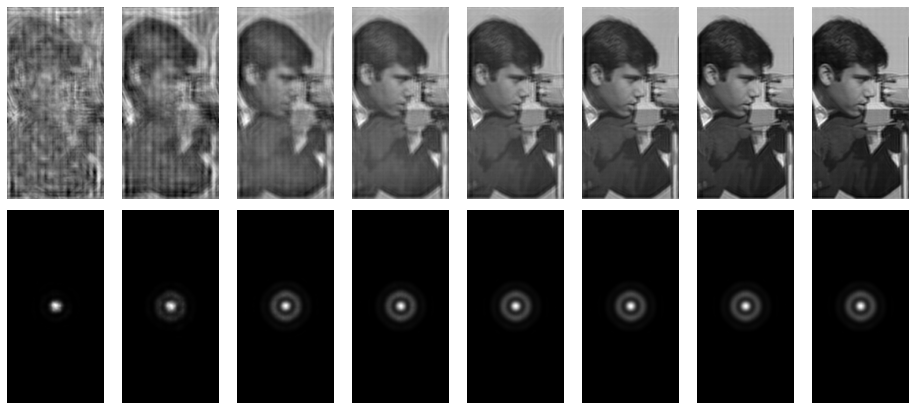

In [13]:
fig, axes = plt.subplots(2, len(reconstructions[0]), figsize=(13,5.8))

for i in range(axes.shape[1]):
    axes[0,i].imshow(np.angle(reconstructions[0][i].array).T, origin='lower', cmap='gray')
    axes[1,i].imshow(np.abs(reconstructions[1][i].array).T ** 2, origin='lower', cmap='gray')
    
    for ax in (axes[0,i], axes[1,i]):
        ax.axis('off')
    
plt.tight_layout()